In [112]:
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, TraceEnum_ELBO, Predictive, NUTS, MCMC, config_enumerate
from pyro.infer.autoguide import AutoDelta, AutoDiagonalNormal, AutoMultivariateNormal
from pyro.optim import Adam, ClippedAdam
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from pyro.distributions import MultivariateNormal as MN

In [2]:
# Load data files

X_train_tensor, X_val_tensor, X_test_tensor =   torch.load("./data/X_train_tensor.pt"), \
                                                torch.load("./data/X_val_tensor.pt"),   \
                                                torch.load("./data/X_test_tensor.pt")
U_train_tensor, U_val_tensor, U_test_tensor =   torch.load("./data/U_train_tensor.pt"), \
                                                torch.load("./data/U_val_tensor.pt"),   \
                                                torch.load("./data/U_test_tensor.pt")
N_t_train, N_t_valid, N_t_test = np.load("./data/N_t_train.npy"), \
                                 np.load("./data/N_t_val.npy"),   \
                                 np.load("./data/N_t_test.npy")

# Concatenation
X_train_val = torch.cat((X_train_tensor, X_val_tensor), 1)
U_train_val = torch.cat((U_train_tensor, U_val_tensor), 1)

In [3]:
# Create input for mixture model
X_train_full = np.zeros((np.sum(N_t_train), 2))
prev_count = 0
for i, count in enumerate(N_t_train):
    X_train_full[prev_count:(prev_count+count), :] = X_train_tensor[:, i, :count, :].numpy()[0]
    prev_count+=count
    
# Create validation set
X_val_full = np.zeros((np.sum(N_t_valid), 2))
prev_count = 0
for i, count in enumerate(N_t_valid):
    X_val_full[prev_count:(prev_count+count), :] = X_val_tensor[:, i, :count, :].numpy()[0]
    prev_count+=count

# Create test set
X_test_full = np.zeros((np.sum(N_t_test), 2))
prev_count = 0
for i, count in enumerate(N_t_test):
    X_test_full[prev_count:(prev_count+count), :] = X_test_tensor[:, i, :count, :].numpy()[0]
    prev_count+=count
    
    
# Train GMM model 
from sklearn.mixture import GaussianMixture

# Initialise and fit model
baseline = GaussianMixture(n_components=5).fit(X_train_full)

# Compute loglikelihood
baseline_ll_train = baseline.score(X_train_full) * np.sum(N_t_train)
baseline_ll_validation = baseline.score(X_val_full) * np.sum(N_t_valid)
baseline_ll_test = baseline.score(X_test_full) * np.sum(N_t_test)
print(f'Baseline training LL:\t{baseline_ll_train:.4f}')
print(f'Baseline validation LL:\t{baseline_ll_validation:.4f}')
print(f'Baseline testing LL:\t{baseline_ll_test:.4f}')

Baseline training LL:	-16784.1908
Baseline validation LL:	-9137.5030
Baseline testing LL:	-7434.1027


In [4]:
# Class for extracting data

class RFNDataset(Dataset):
    """Spatio-temporal demand modelling dataset."""
    def __init__(self, X, U):
        self.X = X
        self.U = U

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        X_i, U_i = self.X[idx].float(), self.U[idx].float()
        return X_i, U_i

In [15]:
# Recurrent Mixture Density network

class RMDN(nn.Module):
    """
    PyTorch class for Recurrent Mixture Density Network
    Inputs:
        input_dim:  dimension of input tensor U
        hidden_dim: number of hidden units to be used in various hidden layers
        output_dim: dimension of output, lat/lon
        K: number of mixture components
        
    Outputs:
        loc:    Tensor of mean values for Gaussians
        pi:     Mixture components
        Cov:    Covariance matrices
        hidden: Hidden states
    
    """
    def __init__(self, input_dim, hidden_dim, output_dim, K):
        super(RMDN, self).__init__()
        # Define parameters
        self.input_dim = input_dim
        self.hidden_dim= hidden_dim
        self.output_dim= output_dim
        self.K = K 
        self.tril_indices = torch.tril_indices(row=output_dim, col=output_dim, offset=-1)

        # Define LSTM
        self.lstm = nn.LSTM(input_size=self.input_dim,
                            hidden_size=self.hidden_dim,
                            num_layers=1)
        # Fully connected layer 
        self.lstm_to_hidden     = nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim)
        self.hidden_to_hidden   = nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim)
        # Take output of fully connected layer and feed to layers for GMM components
        self.hidden_to_loc      = nn.Linear(in_features=self.hidden_dim, out_features=self.K*self.output_dim)
        self.hidden_to_sigma    = nn.Linear(in_features=self.hidden_dim, out_features=self.K*self.output_dim)
        self.hidden_to_off_diag = nn.Linear(in_features=self.hidden_dim, out_features=self.K)
        self.hidden_to_mix      = nn.Linear(in_features=self.hidden_dim, out_features=self.K)
        
        # Functions
        self.relu = nn.ReLU()
        self.elu  = nn.ELU()
        self.softmax = nn.Softmax(dim=1)
        self.softplus = nn.Softplus()
        
        # Dropout
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)
        
    def forward(self, U, hidden):     
        # Feed through LSTM
        y, hidden = self.lstm(U.view(-1, 1, self.input_dim), hidden)
        # Fully connected
        y     = self.dropout1(self.elu(self.lstm_to_hidden(y)))
        y     = self.dropout2(self.elu(self.hidden_to_hidden(y)))
        # Compute mean values
        loc   = self.hidden_to_loc(y).view(-1, self.K, self.output_dim)
        # Compute variances (must be positive)
        sigma = self.softplus(self.hidden_to_sigma(y)).view(-1, self.K, self.output_dim)
        # Compute covariances
        cov   = self.hidden_to_off_diag(y).view(-1, self.K, 1)
        # Compute mixture components (must sum to 1)
        pi    = self.softmax(self.hidden_to_mix(y).view(-1,self.K, 1))
        # Create full covariance matrix
        cov_tril = torch.zeros((U.shape[0], self.K, self.output_dim, self.output_dim))
        for i in range(self.K):
            cov_tril[:, i, self.tril_indices[0], self.tril_indices[1]] = cov[:, i, :]
            cov_tril[:, i] += torch.diag_embed(sigma[:, i, :])
        
        return (loc, pi, cov_tril), hidden
    
    def init_hidden(self):
        # Initialise hidden states
        return (torch.zeros(1, 1, self.hidden_dim), torch.zeros(1, 1, self.hidden_dim))
    
    def get_loglikelihood(self, U, X, mask, U_init=None):
        # Feed U_init through network to obtain beginning hidden states
        hidden = self.init_hidden()
        if U_init is not None:
            for i in range(U_init.size(1)):
                _, hidden = self.forward(U=U_init[:, i, :, :], hidden=hidden)
        
        # Compute loglikelihood
        logprob = 0
        T_max = U.size(1)
        with torch.no_grad():
            for t in range(0, T_max):
                # Extract components for current GMM
                (loc, pi, cov), hidden = self.forward(U=U[:, t, :, :], hidden=hidden)
                # Compute loglikelihood for all datapoints for current time interval
                for tt in range(mask[t]):
                    current_prob = 0
                    for i in range(self.K):
                        current_prob += pi.squeeze()[i] * torch.exp(MN(loc=loc.squeeze()[i], scale_tril=cov[:, i, :, :].squeeze()).log_prob(X[:, t, tt, :]))
                    logprob += torch.log(current_prob)
        return logprob
        
# Pyro version      
class PyroRMDN(nn.Module):
    """
    Generative model for the above RMDN.
    The class is used for training and sampling.
    """
    
    def __init__(self, input_dim, hidden_dim, output_dim, K, grid):
        super(PyroRMDN, self).__init__()
        # Initialise recurrent mixture density network
        self.RMDN = RMDN(input_dim, hidden_dim, output_dim, K)
        self.K = K
        self.output_dim = output_dim
        self.grid = grid        
        
    @config_enumerate   
    def model(self, X=None, U=None, mask=None, hidden=None, batch_size=1):
        # Number of sequences
        N = len(U)
        # Number of time steps
        T_max = U.size(1)
        # Batch size
        b = min(N, batch_size)
        # Dimension check
        assert U.shape == (N, T_max, self.grid, self.grid)       
        # Initialise sample tensor
        x_samples = torch.zeros((b, T_max, max(mask), 2))
        # Register with Pyro
        pyro.module("RMDN",self)
        # Main plate
        with pyro.plate("data", N, dim=-2):
            # Iterate through each time interval
            for t in pyro.markov(range(0, T_max)):
                # Extract mixture components
                (loc, pi, cov), hidden = self.RMDN(U[:, t, :, :], hidden)              
                with pyro.plate('density_%d'%t, size=mask[t], dim=-1):
                    # Draw which component
                    assignment = pyro.sample(f'assignment_{t}', dist.Categorical(pi.view(-1, self.K)).to_event(1))
                    # Extract corresponding mean and covariance
                    _loc = loc[:, assignment, :].view(-1, 2)
                    _cov = cov[:, assignment, :, :].view(-1, 2, 2)
                    # Draw sample as multivariate normal
                    if X is None:
                        x_samples[:, t, :mask[t]] = pyro.sample('x_%d'%t, MN(loc=_loc, scale_tril=_cov),obs=None)
                    else:
                        x_samples[:, t, :mask[t]] = pyro.sample('x_%d'%t, MN(loc=_loc, scale_tril=_cov),obs=X[:, t, :mask[t], :])

        return x_samples
    
    def guide(self, X=None, U=None, mask=None, hidden=None):
        pass
    
    def get_loglikelihood(self, U, X, mask, U_init):
        return self.RMDN.get_loglikelihood(U, X, mask, U_init)


In [16]:
dataset  = RFNDataset(X_train_tensor, U_train_tensor)
dataloader= DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

In [17]:

grid = U_train_tensor.size(3)
pyronet = PyroRMDN(input_dim=grid*grid, hidden_dim=128, output_dim=2, K=100, grid=grid)
guide = pyronet.guide # AutoMultivariateNormal(pyronet)
optimizer = pyro.optim.Adam({"lr": 0.001})
svi = SVI(pyronet.model, guide, optimizer, TraceEnum_ELBO(num_particles=1, max_plate_nesting=1))

In [ ]:
pyro.clear_param_store()
num_epochs = 10000
train_losses = []
val_losses = []
train_ll = []
validation_ll =  []
hidden = pyronet.RMDN.init_hidden()
for i in range(num_epochs):
    for X_i, U_i in dataloader:
        # Set model to training
        pyronet.train()
        # Take step and update parameters
        loss = svi.step(X_i, U_i, N_t_train, hidden) / (N_t_train.sum())
        # Save current loss
        train_losses.append(loss)       
        if i%100 == 99 or i == 0:
            # Set model to evaluation
            pyronet.eval()
            # Compute validation LL
            train_ll_i      = pyronet.get_loglikelihood(X=X_i, U=U_i, mask=N_t_train, U_init=None)
            validation_ll_i = pyronet.get_loglikelihood(X=X_val_tensor, U=U_val_tensor, mask=N_t_valid, U_init=U_i)
            train_ll.append(train_ll_i)
            validation_ll.append(validation_ll_i)
            
            print(f"Epoch: {i+1}, \tLoss: {loss:.3f}, \tTrain LL: {train_ll_i.numpy()[0]}, \tValidation LL: {validation_ll_i.numpy()[0]}")
        

Epoch: 1, 	Loss: 7.774, 	Train LL: -22909.08984375, 	Validation LL: -12274.6748046875
Epoch: 100, 	Loss: 7.328, 	Train LL: -20131.837890625, 	Validation LL: -10839.931640625
Epoch: 200, 	Loss: 7.316, 	Train LL: -20076.130859375, 	Validation LL: -10846.65234375
Epoch: 300, 	Loss: 7.309, 	Train LL: -20058.08203125, 	Validation LL: -10855.0126953125


In [121]:
# Test
# Create concatenated train-validation tensor as primer for testing
U_test_primer = torch.cat((U_train_tensor, U_val_tensor), 1)
test_ll = pyronet.get_loglikelihood(X=X_val_tensor, U=U_val_tensor, mask=N_t_valid, U_init=U_test_primer)
print(f"Test LL: {test_ll.numpy()[0]}")

Test LL: -10980.40234375


## Visualise results

In [122]:
# Run model and obtain distributions

# Initialise hidden states and feed training data through network
hidden = pyronet.RMDN.init_hidden()
for i in range(U_train_tensor.size(1)):
    _, hidden = pyronet.RMDN(U=U_train_tensor[:, i, :, :], hidden=hidden)
    
# Time step
time = 30
for t in range(0,time):
    # Extract components for current GMM
    (loc, pi, cov), hidden = pyronet.RMDN(U=U_val_tensor[:, t, :, :], hidden=hidden)
mix_dist = dist.Categorical(pi.squeeze().detach())

loc = loc.squeeze().detach()
cov = cov.squeeze().detach()

num_samples = 1000
samples = torch.zeros((num_samples, 2))
# Sample from distribution
for i in range(num_samples):
    # Determine distribution to sample from
    assignment = pyro.sample('assignment', mix_dist)
    # Draw current sample
    samples[i, :] = pyro.sample('sample', MN(loc=loc[assignment], scale_tril=cov[assignment]))
samples = samples.numpy()

In [123]:
latmean = 55.67777941810432
latstd  = 0.022970362839316014
lonmean = 12.572154878154388
lonstd  = 0.03018063809393041

lon = samples[:, 0]*lonstd+lonmean
lat = samples[:, 1]*latstd+latmean

loc_np = loc.detach().squeeze().numpy()

In [124]:
loc_np[:, 0] = loc_np[:, 0]*lonstd+lonmean
loc_np[:, 1] = loc_np[:, 1]*latstd+latmean

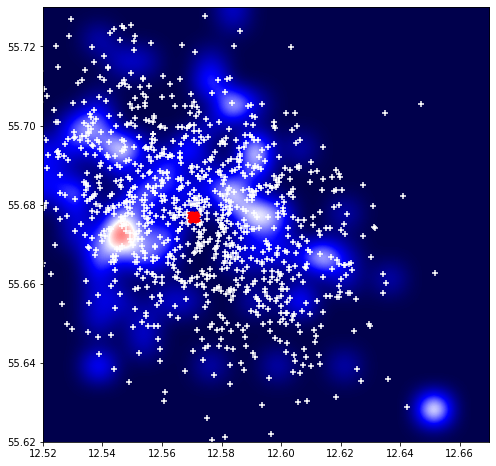

In [125]:
# Visualise U
U_val_np = U_val_tensor[:, time+1, :, :].squeeze().detach().numpy()

(lonMin, lonMax, latMin, latMax) = (12.52, 12.67, 55.62, 55.73)
extent=(lonMin, lonMax, latMin, latMax)
numplot = num_samples
fig = plt.figure(figsize=(8,8))
plt.imshow(U_val_np, interpolation='bicubic',cmap='seismic', aspect='auto', extent=extent)
plt.scatter(x=lon[:numplot],y=lat[:numplot], color='w', marker='+')
plt.scatter(x=loc_np[:,0], y=loc_np[:,1], color='r', marker='x')
plt.xlim([lonMin, lonMax])
plt.ylim([latMin, latMax])
plt.show()